<a href="https://colab.research.google.com/github/shumshersubashgautam/QuantumGAN-HighEnergyPhysics/blob/main/Variational_Quantum_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
  # install packages needed for this task
  !pip install tensorflow==2.3.1
  !pip install tensorflow_quantum==0.4.0
  !pip install quple==0.7.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 KB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast

In [2]:
import tensorflow_quantum as tfq
import tensorflow as tf
import quple
import cirq

In [3]:
# download training data (hmumu 2jet)
!wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/hmumu_twojet_0719.npy

--2023-02-24 15:35:25--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/hmumu_twojet_0719.npy
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.185.34.83, 188.185.25.203, 188.185.31.211, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.185.34.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2032704 (1.9M) [application/octet-stream]
Saving to: ‘hmumu_twojet_0719.npy’

hmumu_twojet_0719.n 100%[===================>]   1.94M  --.-KB/s    in 0.1s    

2023-02-24 15:35:25 (14.4 MB/s) - ‘hmumu_twojet_0719.npy’ saved [2032704/2032704]



In [4]:
import numpy as np
# prepare training data
data = np.load('hmumu_twojet_0719.npy')
x = data[:,:-1]
y = data[:,-1]
print('x: shape = {}'.format(x.shape))
print(x)
print('y: shape = {}'.format(y.shape))
print(y)

x: shape = (18148, 13)
[[ 1.35123826e+02  9.97897017e-01  9.58638570e-01 ...  4.58769383e-01
  -3.05654504e+00  1.80854129e+03]
 [ 2.43290406e+02  3.03747750e-01  6.74568519e-01 ... -1.34468994e+00
  -2.72506172e+00  5.11933555e+02]
 [ 1.64464537e+02 -5.81922591e-02  5.42151745e-02 ... -6.23148328e-01
   3.07514485e+00  3.44958465e+02]
 ...
 [ 2.16542712e+01 -3.05524425e+00  4.59151309e-01 ...  9.26630829e-01
   3.08020790e+00  5.62347204e+02]
 [ 4.19387585e+01  1.89239955e+00  4.48033832e-01 ...  1.73410377e+00
  -2.62992120e+00  1.44320990e+02]
 [ 9.33202609e+01  8.70685882e-01  8.74988118e-01 ... -1.21892943e+00
   2.85587492e+00  2.03240716e+02]]
y: shape = (18148,)
[1. 1. 1. ... 0. 0. 0.]


In [5]:
# let's say we want to train on a circuit with 5 qubit
n_qubit = 5
# let's say we want to train on 1000 events
n_event = 1000

In [6]:
# prepare data preprocessors from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# we apply 3 data preprocessors
# 1. PCA to reduce the dimension to 5 to fit the 5 qubit circuit
# 2. StandardScaler to standardize features by removing the mean and scaling to unit variance
# 3. MinMaxScaler to bound the data in the range [-1,+1]
preprocessors = [PCA(n_components=n_qubit, random_state=3), StandardScaler(), MinMaxScaler((-1,1))]

In [7]:
from quple.components.data_preparation import prepare_train_val_test
# split the data into training set, validation set and test set
x_train, x_val, x_test, y_train, y_val, y_test = prepare_train_val_test(x, y, train_size=n_event, val_size=n_event, test_size=n_event, preprocessors=preprocessors, random_state=24)
print('x_train: shape = {}'.format(x_train.shape))
print('x_val: shape = {}'.format(x_val.shape))
print('x_test: shape = {}'.format(x_test.shape))
print('y_train: shape = {}'.format(y_train.shape))
print('y_val: shape = {}'.format(y_val.shape))
print('y_test: shape = {}'.format(y_test.shape))

x_train: shape = (1000, 5)
x_val: shape = (1000, 5)
x_test: shape = (1000, 5)
y_train: shape = (1000,)
y_val: shape = (1000,)
y_test: shape = (1000,)


In [8]:
from quple.data_encoding import FirstOrderPauliZEncoding, SecondOrderPauliZEncoding
from quple.data_encoding.encoding_maps import self_product, cosine_product, modified_cosine_product, distance_measure, arithmetic_mean, polynomial

In [9]:
# let's try the first order pauli z encoding circuit with depth 2
encoding_circuit = FirstOrderPauliZEncoding(feature_dimension=n_qubit, copies=2)
# Notice that there is a default scale factor of pi added to the encoding function 
# since we assume the input is in the range [-1, +1]. You can override this behavior
# by passing the argument parameter_scale=1 to the initializer
encoding_circuit

(0, 0): ───H───Rz(pi*x_0)───H───Rz(pi*x_0)───

(0, 1): ───H───Rz(pi*x_1)───H───Rz(pi*x_1)───

(0, 2): ───H───Rz(pi*x_2)───H───Rz(pi*x_2)───

(0, 3): ───H───Rz(pi*x_3)───H───Rz(pi*x_3)───

(0, 4): ───H───Rz(pi*x_4)───H───Rz(pi*x_4)───

**Construct Variational Circuit**

In [10]:
from quple.circuits.variational_circuits import EfficientSU2

In [11]:
# let's try the Efficient SU2 variational circuit with depth 2
variational_circuit = EfficientSU2(n_qubit=n_qubit, copies=2)
#The readout qubit will be entangled to all input qubits via certain two qubit gate operations
variational_circuit.add_readout('XX')
variational_circuit

┌──┐       ┌──┐                                                ┌──┐       ┌──┐
(-1, -1): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────XX──────────XX──────────XX──────────XX──────────XX──────────
                                                                                                                                                        │           │           │           │           │
(0, 0): ─────Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────Ry(θ_10)───Rz(θ_15)───@──────────@───@────@────────────────────Ry(θ_20)───Rz(θ_25)───XX^(θ_30)───┼───────────┼───────────┼───────────┼───────────
                                 │   │   │    │                                          │          │   │    │                                                      │           │           │           │
(0, 1): ─────Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────Ry(θ_11)───Rz(θ_16)───X──────────┼───┼────┼@────@────@─────────Ry(θ_21)───Rz(θ_26)───────────────XX^(θ_31)───┼───────────┼───────────┼───────────
                                     │   │    ││    │    │                                          │   │    ││    │    │                                                       │           │           │
(0, 2): ─────Ry(θ_2)───Rz(θ_7)───────X───┼────┼X────┼────┼@────@───Ry(θ_12)───Rz(θ_17)──────────────X───┼────┼X────┼────┼@────@───Ry(θ_22)───Rz(θ_27)───────────────────────────XX^(θ_32)───┼───────────┼───────────
                                         │    │     │    ││    │                                        │    │     │    ││    │                                                             │           │
(0, 3): ─────Ry(θ_3)───Rz(θ_8)───────────X────┼─────X────┼X────┼───@──────────Ry(θ_13)───Rz(θ_18)───────X────┼─────X────┼X────┼───@──────────Ry(θ_23)───Rz(θ_28)────────────────────────────XX^(θ_33)───┼───────────
                                              │          │     │   │                                         │          │     │   │                                                                     │
(0, 4): ─────Ry(θ_4)───Rz(θ_9)────────────────X──────────X─────X───X──────────Ry(θ_14)───Rz(θ_19)────────────X──────────X─────X───X──────────Ry(θ_24)───Rz(θ_29)────────────────────────────────────────XX^(θ_34)───
                                             └──┘       └──┘                                                └──┘       └──┘

In [12]:
print('Readout qubit:')
print(variational_circuit.readout_qubit)

Readout qubit:
(-1, -1)


**Build the VQC Model**

In [13]:
from quple.classifiers import VQC
# let's use the following settings
# optimizer = Adam (learning rate = 0.01)
# metrics = binary accuracy and auc
# loss = mean squared loss

# construct the vqc model
vqc = VQC(encoding_circuit, variational_circuit,
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          metrics=['binary_accuracy','qAUC'],
          readout=[cirq.Z(variational_circuit.readout_qubit)],
          loss='mse',
          random_state=16)

Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35


In [14]:
from quple.classifiers import VQC
# let's use the following settings
# optimizer = Adam (learning rate = 0.01)
# metrics = binary accuracy and auc
# loss = mean squared loss

# construct the vqc model
vqc = VQC(encoding_circuit, variational_circuit,
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          metrics=['binary_accuracy','qAUC'],
          readout=[cirq.Z(variational_circuit.readout_qubit)],
          loss='mse',
          random_state=16)

Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35


**Train the Classifier**

In [15]:
# train the vqc model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
vqc.fit(x_train, y_train,
        batch_size=64,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=[callback])

Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...


Epoch 1/10
16/16 [==============================] - 5s 290ms/step - loss: 0.3208 - binary_accuracy: 0.4950 - q_auc_1: 0.4627 - val_loss: 0.2617 - val_binary_accuracy: 0.5530 - val_q_auc_1: 0.5720
Epoch 2/10
16/16 [==============================] - 7s 410ms/step - loss: 0.2625 - binary_accuracy: 0.5460 - q_auc_1: 0.5457 - val_loss: 0.2313 - val_binary_accuracy: 0.6640 - val_q_auc_1: 0.6930
Epoch 3/10
16/16 [==============================] - 6s 386ms/step - loss: 0.2345 - binary_accuracy: 0.6490 - q_auc_1: 0.6776 - val_loss: 0.2130 - val_binary_accuracy: 0.7050 - val_q_auc_1: 0.7804
Epoch 4/10
16/16 [==============================] - 4s 260ms/step - loss: 0.2154 - binary_accuracy: 0.6940 - q_auc_1: 0.7565 - val_loss: 0.2005 - val_binary_accuracy: 0.7670 - val_q_auc_1: 0.8242
Epoch 5/10
16/16 [==============================] - 2s 129ms/step - loss: 0.1991 - binary_accuracy: 0.7310 - q_auc_1: 0.8035 - val_loss: 0.1895 - val_binary_accuracy: 0.7280 - val_q_auc_1: 0.8433
Epoch 6/10
16/16 [==

**Evaluate the Result**

In [16]:
# test the model
y_score = vqc.predict(x_test)
y_score

Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...


array([[0.25551373],
       [0.6398509 ],
       [0.41366142],
       [0.26453093],
       [0.49183765],
       [0.2348524 ],
       [0.73499465],
       [0.7907396 ],
       [0.6652454 ],
       [0.3003377 ],
       [0.22771463],
       [0.23009677],
       [0.60608107],
       [0.22311182],
       [0.2531095 ],
       [0.47869414],
       [0.28882077],
       [0.32856354],
       [0.34647334],
       [0.5463053 ],
       [0.24785581],
       [0.25187412],
       [0.67950815],
       [0.30801362],
       [0.6309235 ],
       [0.68329227],
       [0.25191846],
       [0.29563126],
       [0.21535566],
       [0.4681913 ],
       [0.852528  ],
       [0.44572547],
       [0.22500533],
       [0.5449783 ],
       [0.27084765],
       [0.2666558 ],
       [0.6666239 ],
       [0.39774704],
       [0.5408343 ],
       [0.7263391 ],
       [0.3182584 ],
       [0.72660583],
       [0.22287221],
       [0.3159271 ],
       [0.7518629 ],
       [0.22200707],
       [0.229734  ],
       [0.829

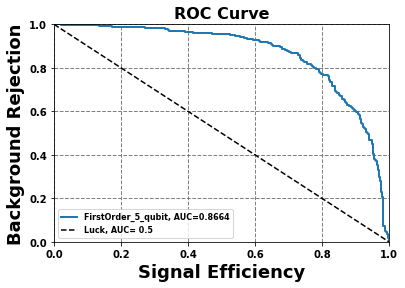

In [17]:
  # plot a roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score)
plt = quple.utils.utils.plot_roc_curve(fpr, tpr, label='FirstOrder_5_qubit', title='ROC Curve')

In [18]:
# Try out different encoding maps and using SecondOrderExpansion encoding circuit
# encoding map = self_product ~ x_0*x_1*x_2...
second_order_self_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, entangle_strategy='linear')
second_order_self_product

(0, 0): ───H───Rz(pi*x_0)───@──────────────────────@────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@───────────────────────────────@────────────────────────────────────────────────────────────────────────────────────
                            │                      │                                                                                                 │                               │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────────
                                                       │                      │                                                                                                          │                      │
(0, 2): ───H───Rz(pi*x_2)──────────────────────────────X───Rz(pi*<x_1*x_2>)───X───@──────────────────────@──────────────────────────H───Rz(pi*x_2)───────────────────────────────────────X───Rz(pi*<x_1*x_2>)───X───@──────────────────────@──────────────────────────────
                                                                                  │                      │                                                                                                          │                      │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────X───Rz(pi*<x_2*x_3>)───X───@──────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────X───Rz(pi*<x_2*x_3>)───X───@──────────────────────@───
                                                                                                             │                      │                                                                                                          │                      │
(0, 4): ───H───Rz(pi*x_4)────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3*x_4>)───X───H────────────Rz(pi*x_4)────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3*x_4>)───X───

In [19]:
# encoding map = cosine_product ~ cos(x_0)*cos(x_1)*...
second_order_cosine_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=cosine_product, entangle_strategy='linear')
second_order_cosine_product

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                                │                                                                                                                               │                                         │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────
                                                                 │                                │                                                                                                                                        │                                │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────────X───Rz(pi*<cos(x_1)*cos(x_2)>)───X───@────────────────────────────────@────────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────────X───Rz(pi*<cos(x_1)*cos(x_2)>)───X───@────────────────────────────────@────────────────────────────────────────
                                                                                                      │                                │                                                                                                                                        │                                │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_2)*cos(x_3)>)───X───@────────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_2)*cos(x_3)>)───X───@────────────────────────────────@───
                                                                                                                                           │                                │                                                                                                                                        │                                │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_3)*cos(x_4)>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<cos(x_3)*cos(x_4)>)───X───

In [20]:
# encoding map = distance_measure ~ (x_0-x_1)*(x_1-x_2)*(x_2-x_3)/2**(number of pairs)...
second_order_distance_measure = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=distance_measure, entangle_strategy='linear')
second_order_distance_measure

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                                                                            │                            │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────X───Rz(pi*<x_1/2 - x_2/2>)───X───@────────────────────────────@────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────X───Rz(pi*<x_1/2 - x_2/2>)───X───@────────────────────────────@────────────────────────────────────
                                                                                              │                            │                                                                                                                            │                            │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 - x_3/2>)───X───@────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 - x_3/2>)───X───@────────────────────────────@───
                                                                                                                               │                            │                                                                                                                            │                            │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 - x_4/2>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 - x_4/2>)───X───

In [21]:
# encoding map = arithmetic_mean ~ (x_0+x_1+x_2+...)/N...
second_order_arithmetic_mean = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=arithmetic_mean, entangle_strategy='linear')
second_order_arithmetic_mean

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                                                                            │                            │
(0, 2): ───H───Rz(pi*x_2)────────────────────────────────────X───Rz(pi*<x_1/2 + x_2/2>)───X───@────────────────────────────@────────────────────────────────H───Rz(pi*x_2)─────────────────────────────────────────────X───Rz(pi*<x_1/2 + x_2/2>)───X───@────────────────────────────@────────────────────────────────────
                                                                                              │                            │                                                                                                                            │                            │
(0, 3): ───H───Rz(pi*x_3)─────────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 + x_3/2>)───X───@────────────────────────────@───H────────────Rz(pi*x_3)─────────────────────────────────────────────────────────────────X───Rz(pi*<x_2/2 + x_3/2>)───X───@────────────────────────────@───
                                                                                                                               │                            │                                                                                                                            │                            │
(0, 4): ───H───Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 + x_4/2>)───X───H────────────Rz(pi*x_4)──────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<x_3/2 + x_4/2>)───X───

In [22]:
# construct the models with the various encoding circuits
my_models = [
  VQC(second_order_self_product, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_cosine_product, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_distance_measure, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_arithmetic_mean, variational_circuit, metrics=['binary_accuracy','qAUC'], loss='mse', readout=[cirq.Z(variational_circuit.readout_qubit)], random_state=16)
]

Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered va

In [23]:
# create the tensor form of the resolved encoding circuits (this can be fed to model.fit directly so that the conversion does not happen inside fit)
x_train_tensors = [model.convert_to_tensor(x_train) for model in my_models]
x_val_tensors = [model.convert_to_tensor(x_val) for model in my_models]
x_test_tensors = [model.convert_to_tensor(x_test) for model in my_models]

Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.class

In [24]:
# train the models
# you may increase the number of epochs if it did not converge 
for i,model in enumerate(my_models):
    model.fit(x_train_tensors[i], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=(x_val_tensors[i], y_val),
              callbacks=[callback])

Epoch 1/10
16/16 [==============================] - 3s 180ms/step - loss: 0.5109 - binary_accuracy: 0.4990 - q_auc_2: 0.6037 - val_loss: 0.4825 - val_binary_accuracy: 0.4960 - val_q_auc_2: 0.6475
Epoch 2/10
16/16 [==============================] - 3s 191ms/step - loss: 0.4636 - binary_accuracy: 0.4990 - q_auc_2: 0.6044 - val_loss: 0.4365 - val_binary_accuracy: 0.4960 - val_q_auc_2: 0.6476
Epoch 3/10
16/16 [==============================] - 7s 465ms/step - loss: 0.4208 - binary_accuracy: 0.4990 - q_auc_2: 0.5992 - val_loss: 0.3951 - val_binary_accuracy: 0.4960 - val_q_auc_2: 0.6477
Epoch 4/10
16/16 [==============================] - 3s 168ms/step - loss: 0.3820 - binary_accuracy: 0.4990 - q_auc_2: 0.6089 - val_loss: 0.3614 - val_binary_accuracy: 0.4960 - val_q_auc_2: 0.6502
Epoch 5/10
16/16 [==============================] - 3s 167ms/step - loss: 0.3516 - binary_accuracy: 0.4990 - q_auc_2: 0.6043 - val_loss: 0.3325 - val_binary_accuracy: 0.4960 - val_q_auc_2: 0.6530
Epoch 6/10
16/16 [==

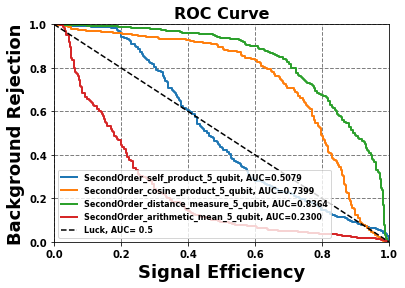

In [25]:
# plot the roc curves
fpr_list, tpr_list = [], []
for i,model in enumerate(my_models):
    y_score = vqc.predict(x_test_tensors[i])
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
labels = ['SecondOrder_self_product_5_qubit',
          'SecondOrder_cosine_product_5_qubit',
          'SecondOrder_distance_measure_5_qubit',
          'SecondOrder_arithmetic_mean_5_qubit']
multi_model_plt = quple.utils.utils.plot_stacked_roc_curve(fpr_list, tpr_list, labels)

**The VQC Logger**

The following will be saved to a log text file as well as a npz file

Number of qubits


Qubit layout


Name of encoding circuit

Name of encoding map

Name of variational circuit

Circuit parameters

Number of parameters

Name of Optimizer

Name of Loss Function

Name of Activation Function

Name of Metrics

Train Size

Val Size

Test Size

Batch Size

Number of Epochs

Circuit Diagram for Encoding Circuit

Circuit Diagram for Variational Circuit

Losses in each epoch

Model weights after training

fpr for roc curve

tpr for roc curve

auc for roc curve

The following will be saved as a png file





A ROC curve plot

In [27]:
from quple.classifiers.vqc_logger import VQCLogger
logger = VQCLogger()

Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
2023-02-24 15:43:57,480 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
INFO:quple.classifiers.vqc_logger:######## Executing VQC with the following attributes ########
2023-02-24 15:43:57,484 [MainThread  ][INFO ]  Feature Dimension: 5
INFO:quple.classifiers.vqc_logger:Feature Dimension: 5
2023-02-24 15:43:57,489 [MainThread  ][INFO ]  Number of Qubits: 5
INFO:quple.classifiers.vqc_logger:Number of Qubits: 5
2023-02-24 15:43:57,491 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
INFO:quple.classifiers.vqc_logger:Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2023-02-24 15:43:57,494 [MainT

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 0.1709 - binary_accuracy: 0.7470 - q_auc_1: 0.8552

DEBUG:quple.classifiers.vqc_logger:######## Epoch 0 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1709294617176056
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.746999979019165
DEBUG:quple.classifiers.vqc_logger:q_auc_1: 0.8552154302597046
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17049528658390045
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:val_q_auc_1: 0.8492583632469177


16/16 [==============================] - 3s 162ms/step - loss: 0.1709 - binary_accuracy: 0.7470 - q_auc_1: 0.8552 - val_loss: 0.1705 - val_binary_accuracy: 0.7600 - val_q_auc_1: 0.8493
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.7590 - q_auc_1: 0.8591

DEBUG:quple.classifiers.vqc_logger:######## Epoch 1 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1687323898077011
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:q_auc_1: 0.8590594530105591
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17018374800682068
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7509999871253967
DEBUG:quple.classifiers.vqc_logger:val_q_auc_1: 0.8486903309822083


16/16 [==============================] - 2s 130ms/step - loss: 0.1687 - binary_accuracy: 0.7590 - q_auc_1: 0.8591 - val_loss: 0.1702 - val_binary_accuracy: 0.7510 - val_q_auc_1: 0.8487
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.1680 - binary_accuracy: 0.7570 - q_auc_1: 0.8601

DEBUG:quple.classifiers.vqc_logger:######## Epoch 2 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16797375679016113
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7570000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_1: 0.860073447227478
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1692906618118286
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7549999952316284
DEBUG:quple.classifiers.vqc_logger:val_q_auc_1: 0.84846431016922


16/16 [==============================] - 2s 129ms/step - loss: 0.1680 - binary_accuracy: 0.7570 - q_auc_1: 0.8601 - val_loss: 0.1693 - val_binary_accuracy: 0.7550 - val_q_auc_1: 0.8485
Epoch 4/5
16/16 [==============================] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.7570 - q_auc_1: 0.8430

DEBUG:quple.classifiers.vqc_logger:######## Epoch 3 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16878974437713623
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7570000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_1: 0.8429853916168213
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1725056767463684
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:val_q_auc_1: 0.8472902774810791


16/16 [==============================] - 2s 131ms/step - loss: 0.1688 - binary_accuracy: 0.7570 - q_auc_1: 0.8430 - val_loss: 0.1725 - val_binary_accuracy: 0.7680 - val_q_auc_1: 0.8473
Epoch 5/5
16/16 [==============================] - ETA: 0s - loss: 0.1670 - binary_accuracy: 0.7610 - q_auc_1: 0.8519

DEBUG:quple.classifiers.vqc_logger:######## Epoch 4 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16702167689800262
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:q_auc_1: 0.8519093990325928
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1705722063779831
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7540000081062317
DEBUG:quple.classifiers.vqc_logger:val_q_auc_1: 0.8488883376121521


16/16 [==============================] - 4s 225ms/step - loss: 0.1670 - binary_accuracy: 0.7610 - q_auc_1: 0.8519 - val_loss: 0.1706 - val_binary_accuracy: 0.7540 - val_q_auc_1: 0.8489


2023-02-24 15:44:10,830 [MainThread  ][INFO ]  ######## Training Ends ########
INFO:quple.classifiers.vqc_logger:######## Training Ends ########
2023-02-24 15:44:10,845 [MainThread  ][INFO ]  Model weights: 
[ 3.672414    3.381905    0.2953684   1.4807465   5.275809    6.1557493
  2.0306993   6.164961    1.5752516  -0.20108697  4.952955    0.05443803
  2.5480974   3.2798269   0.6580332   2.570104    0.6585996   1.6024274
  0.45259508  1.4754394   4.9819193   4.9149346  -0.21754701  5.977769
  4.270921    0.26600707  3.0012302  -0.03117078  0.9643001   5.4413385
  4.8850346   2.0866737   2.298294    4.59115     5.5142074 ]
INFO:quple.classifiers.vqc_logger:Model weights: 
[ 3.672414    3.381905    0.2953684   1.4807465   5.275809    6.1557493
  2.0306993   6.164961    1.5752516  -0.20108697  4.952955    0.05443803
  2.5480974   3.2798269   0.6580332   2.570104    0.6585996   1.6024274
  0.45259508  1.4754394   4.9819193   4.9149346  -0.21754701  5.977769
  4.270921    0.26600707  3.0012

31/32 [============================>.] - ETA: 0s - loss: 0.1622 - binary_accuracy: 0.7722 - q_auc_1: 0.8669

2023-02-24 15:44:20,196 [MainThread  ][INFO ]  ######## Test Ends ########
INFO:quple.classifiers.vqc_logger:######## Test Ends ########


32/32 [==============================] - 1s 27ms/step - loss: 0.1629 - binary_accuracy: 0.7700 - q_auc_1: 0.8660


DEBUG:quple.classifiers.vqc_logger:######## ROC curve information ########
DEBUG:quple.classifiers.vqc_logger:fpr:
[0.         0.         0.         0.00192678 0.00192678 0.00385356
 0.00385356 0.00578035 0.00578035 0.00770713 0.00770713 0.00963391
 0.00963391 0.01156069 0.01156069 0.01348748 0.01348748 0.01541426
 0.01541426 0.01734104 0.01734104 0.02119461 0.02119461 0.02312139
 0.02312139 0.02504817 0.02504817 0.02890173 0.02890173 0.03082852
 0.03082852 0.0327553  0.0327553  0.03660886 0.03660886 0.03853565
 0.03853565 0.04046243 0.04046243 0.04238921 0.04238921 0.04238921
 0.04238921 0.04238921 0.04431599 0.04431599 0.04624277 0.04624277
 0.04816956 0.04816956 0.05202312 0.05202312 0.0539499  0.0539499
 0.05587669 0.05587669 0.05780347 0.05780347 0.05973025 0.05973025
 0.06358382 0.06358382 0.0655106  0.0655106  0.06743738 0.06743738
 0.07129094 0.07129094 0.07707129 0.07707129 0.07899807 0.07899807
 0.08092486 0.08092486 0.08285164 0.08285164 0.08477842 0.08477842
 0.0867052  0.0

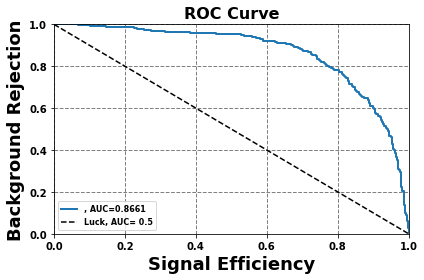

In [28]:
# run the training, evaluation and test
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=5, callbacks=[logger])

In [29]:
#Let's check what files we've got
!ls logs/*

logs/checkpoint
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29.log
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29_model_weights.data-00000-of-00001
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29_model_weights.index
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29.npz
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29_roc_curve.eps
logs/FirstOrderPauliZEncoding_self_product_EfficientSU2_5_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_10_batch_size_64_2023-02-24_15-43-29_roc_curv

In [30]:
#print out the content of the log file
import glob
logfile = glob.glob('logs/*.log')[0]
print(open(logfile, 'r').read())

2023-02-24 15:43:57,480 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
2023-02-24 15:43:57,484 [MainThread  ][INFO ]  Feature Dimension: 5
2023-02-24 15:43:57,489 [MainThread  ][INFO ]  Number of Qubits: 5
2023-02-24 15:43:57,491 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2023-02-24 15:43:57,494 [MainThread  ][INFO ]  Encoding Circuit: FirstOrderPauliZEncoding
2023-02-24 15:43:57,497 [MainThread  ][INFO ]  Encoding Map: self_product
2023-02-24 15:43:57,499 [MainThread  ][INFO ]  Variational Circuit: EfficientSU2
2023-02-24 15:43:57,501 [MainThread  ][INFO ]  Circuit Parameters: ['θ_0', 'θ_1', 'θ_2', 'θ_3', 'θ_4', 'θ_5', 'θ_6', 'θ_7', 'θ_8', 'θ_9', 'θ_10', 'θ_11', 'θ_12', 'θ_13', 'θ_14', 'θ_15', 'θ_16', 'θ_17', 'θ_18', 'θ_19', 'θ_20', 'θ_21', 'θ_22', 'θ_23', 'θ_24', 'θ_25', 'θ_26', 'θ_27', 'θ_28', 'θ_29', 'θ_30', 'θ_31', 'θ_32', 'θ_33', 'θ_34']
2

In [31]:
#print out content of the npz file
npzfile = glob.glob('logs/*.npz')[0]
print(dict(np.load(npzfile, allow_pickle=True)))

{'train_result': array([{'loss': 0.1709294617176056, 'binary_accuracy': 0.746999979019165, 'q_auc_1': 0.8552154302597046, 'val_loss': 0.17049528658390045, 'val_binary_accuracy': 0.7599999904632568, 'val_q_auc_1': 0.8492583632469177, 'epoch': 0},
       {'loss': 0.1687323898077011, 'binary_accuracy': 0.7590000033378601, 'q_auc_1': 0.8590594530105591, 'val_loss': 0.17018374800682068, 'val_binary_accuracy': 0.7509999871253967, 'val_q_auc_1': 0.8486903309822083, 'epoch': 1},
       {'loss': 0.16797375679016113, 'binary_accuracy': 0.7570000290870667, 'q_auc_1': 0.860073447227478, 'val_loss': 0.1692906618118286, 'val_binary_accuracy': 0.7549999952316284, 'val_q_auc_1': 0.84846431016922, 'epoch': 2},
       {'loss': 0.16878974437713623, 'binary_accuracy': 0.7570000290870667, 'q_auc_1': 0.8429853916168213, 'val_loss': 0.1725056767463684, 'val_binary_accuracy': 0.7680000066757202, 'val_q_auc_1': 0.8472902774810791, 'epoch': 3},
       {'loss': 0.16702167689800262, 'binary_accuracy': 0.760999977

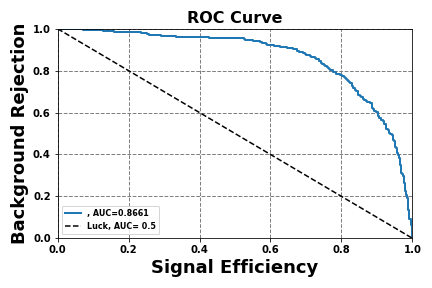

In [32]:
#display the roc curve
from IPython.display import Image
roc_image = glob.glob('logs/*.png')[0]
Image(filename=roc_image) 

In [34]:
# Now try customizing the loggers
# Let's say we want to save the log files in the directory my_logs
log_dir = 'my_logs'
# Let's say we want the file name format to be simply
filename = '{encoding_circuit}_{variational_circuit}_{n_qubit}_{time}'
# do not save npz file
save_npz = False
# do not save the model
save_weights = False
# do not save roc plot
roc_plot = False
# do not print logs unless fatal error messages
import logging
stream_level = logging.CRITICAL
# only save logs of level INFO or higher
file_level = logging.INFO
# only save the auc infos for the training results
keys = ['AUC', 'val_AUC', 'epoch']
logger = VQCLogger(log_dir=log_dir,filename=filename, keys=keys, stream_level=stream_level, file_level=file_level, save_npz=save_npz, save_weights=save_weights)

Registered encoding circuit with feature dimension: 5
INFO:quple.classifiers.vqc:Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
INFO:quple.classifiers.vqc:Registered variational circuit with number of parameters: 35
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
INFO:quple.classifiers.vqc_logger:######## Executing VQC with the following attributes ########
INFO:quple.classifiers.vqc_logger:Feature Dimension: 5
INFO:quple.classifiers.vqc_logger:Number of Qubits: 5
INFO:quple.classifiers.vqc_logger:Qubit Layout: [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
INFO:quple.classifiers.vqc_logger:Encoding Circuit: FirstOrderPauliZEncoding
INFO:quple.classifiers.vqc_logger:Encoding Map: self_product
INFO:quple.classifiers.v

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.4324 - binary_accuracy: 0.4990 - q_auc_6: 0.6038

DEBUG:quple.classifiers.vqc_logger:######## Epoch 0 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.4323669970035553
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6037904024124146
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.4201298952102661
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6172654628753662


16/16 [==============================] - 3s 205ms/step - loss: 0.4324 - binary_accuracy: 0.4990 - q_auc_6: 0.6038 - val_loss: 0.4201 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6173
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.4046 - binary_accuracy: 0.4990 - q_auc_6: 0.6102

DEBUG:quple.classifiers.vqc_logger:######## Epoch 1 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.4046384394168854
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6101844310760498
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.39415228366851807
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6222118139266968


16/16 [==============================] - 2s 130ms/step - loss: 0.4046 - binary_accuracy: 0.4990 - q_auc_6: 0.6102 - val_loss: 0.3942 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6222
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.4990 - q_auc_6: 0.6114

DEBUG:quple.classifiers.vqc_logger:######## Epoch 2 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.382736474275589
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6114444732666016
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.3722499907016754
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6321225166320801


16/16 [==============================] - 2s 131ms/step - loss: 0.3827 - binary_accuracy: 0.4990 - q_auc_6: 0.6114 - val_loss: 0.3722 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6321
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.3638 - binary_accuracy: 0.4990 - q_auc_6: 0.6223

DEBUG:quple.classifiers.vqc_logger:######## Epoch 3 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.36382126808166504
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6222724914550781
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.3534170091152191
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6430791616439819


16/16 [==============================] - 2s 129ms/step - loss: 0.3638 - binary_accuracy: 0.4990 - q_auc_6: 0.6223 - val_loss: 0.3534 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6431
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.3476 - binary_accuracy: 0.4990 - q_auc_6: 0.6241

DEBUG:quple.classifiers.vqc_logger:######## Epoch 4 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.3476351797580719
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.624050498008728
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.33556443452835083
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6535158157348633


16/16 [==============================] - 2s 130ms/step - loss: 0.3476 - binary_accuracy: 0.4990 - q_auc_6: 0.6241 - val_loss: 0.3356 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6535
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.3319 - binary_accuracy: 0.4990 - q_auc_6: 0.6312

DEBUG:quple.classifiers.vqc_logger:######## Epoch 5 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.33194079995155334
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6311885714530945
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.3185337483882904
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.663950502872467


16/16 [==============================] - 3s 218ms/step - loss: 0.3319 - binary_accuracy: 0.4990 - q_auc_6: 0.6312 - val_loss: 0.3185 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6640
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.3168 - binary_accuracy: 0.4990 - q_auc_6: 0.6325

DEBUG:quple.classifiers.vqc_logger:######## Epoch 6 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.31676220893859863
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6324825286865234
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.3019682765007019
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4959999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6687188148498535


16/16 [==============================] - 3s 214ms/step - loss: 0.3168 - binary_accuracy: 0.4990 - q_auc_6: 0.6325 - val_loss: 0.3020 - val_binary_accuracy: 0.4960 - val_q_auc_6: 0.6687
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3021 - binary_accuracy: 0.4990 - q_auc_6: 0.6321

DEBUG:quple.classifiers.vqc_logger:######## Epoch 7 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.3021261394023895
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.49900001287460327
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6320545077323914
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.28666168451309204
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.4970000088214874
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.675193190574646


16/16 [==============================] - 2s 142ms/step - loss: 0.3021 - binary_accuracy: 0.4990 - q_auc_6: 0.6321 - val_loss: 0.2867 - val_binary_accuracy: 0.4970 - val_q_auc_6: 0.6752
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.2888 - binary_accuracy: 0.5080 - q_auc_6: 0.6319

DEBUG:quple.classifiers.vqc_logger:######## Epoch 8 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.28879374265670776
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.5080000162124634
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6318865418434143
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2732270061969757
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.5189999938011169
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6820056438446045


16/16 [==============================] - 2s 129ms/step - loss: 0.2888 - binary_accuracy: 0.5080 - q_auc_6: 0.6319 - val_loss: 0.2732 - val_binary_accuracy: 0.5190 - val_q_auc_6: 0.6820
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.2771 - binary_accuracy: 0.5220 - q_auc_6: 0.6326

DEBUG:quple.classifiers.vqc_logger:######## Epoch 9 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.2771161198616028
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.5220000147819519
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6326005458831787
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2617078125476837
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.5379999876022339
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6869159936904907


16/16 [==============================] - 2s 129ms/step - loss: 0.2771 - binary_accuracy: 0.5220 - q_auc_6: 0.6326 - val_loss: 0.2617 - val_binary_accuracy: 0.5380 - val_q_auc_6: 0.6869
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.2671 - binary_accuracy: 0.5390 - q_auc_6: 0.6345

DEBUG:quple.classifiers.vqc_logger:######## Epoch 10 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.267123818397522
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.5389999747276306
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6344965696334839
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2524707019329071
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.5640000104904175
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.6938364505767822


16/16 [==============================] - 2s 130ms/step - loss: 0.2671 - binary_accuracy: 0.5390 - q_auc_6: 0.6345 - val_loss: 0.2525 - val_binary_accuracy: 0.5640 - val_q_auc_6: 0.6938
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.2587 - binary_accuracy: 0.5580 - q_auc_6: 0.6431

DEBUG:quple.classifiers.vqc_logger:######## Epoch 11 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.258718878030777
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.5580000281333923
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6430705785751343
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.24529029428958893
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.5929999947547913
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7017969489097595


16/16 [==============================] - 2s 151ms/step - loss: 0.2587 - binary_accuracy: 0.5580 - q_auc_6: 0.6431 - val_loss: 0.2453 - val_binary_accuracy: 0.5930 - val_q_auc_6: 0.7018
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.2518 - binary_accuracy: 0.5850 - q_auc_6: 0.6521

DEBUG:quple.classifiers.vqc_logger:######## Epoch 12 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.2518172860145569
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.5849999785423279
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6521085500717163
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.23933374881744385
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6119999885559082
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7076833248138428


16/16 [==============================] - 4s 226ms/step - loss: 0.2518 - binary_accuracy: 0.5850 - q_auc_6: 0.6521 - val_loss: 0.2393 - val_binary_accuracy: 0.6120 - val_q_auc_6: 0.7077
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.2460 - binary_accuracy: 0.6070 - q_auc_6: 0.6602

DEBUG:quple.classifiers.vqc_logger:######## Epoch 13 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.24596622586250305
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6069999933242798
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6601966619491577
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.23469753563404083
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6340000033378601
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7160398364067078


16/16 [==============================] - 3s 201ms/step - loss: 0.2460 - binary_accuracy: 0.6070 - q_auc_6: 0.6602 - val_loss: 0.2347 - val_binary_accuracy: 0.6340 - val_q_auc_6: 0.7160
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2410 - binary_accuracy: 0.6210 - q_auc_6: 0.6713

DEBUG:quple.classifiers.vqc_logger:######## Epoch 14 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.24096499383449554
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6209999918937683
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.671338677406311
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2307509183883667
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6579999923706055
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.723676323890686


16/16 [==============================] - 2s 130ms/step - loss: 0.2410 - binary_accuracy: 0.6210 - q_auc_6: 0.6713 - val_loss: 0.2308 - val_binary_accuracy: 0.6580 - val_q_auc_6: 0.7237
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.2365 - binary_accuracy: 0.6320 - q_auc_6: 0.6867

DEBUG:quple.classifiers.vqc_logger:######## Epoch 15 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.23649071156978607
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6320000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6867027282714844
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.22739987075328827
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6660000085830688
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.732914924621582


16/16 [==============================] - 2s 129ms/step - loss: 0.2365 - binary_accuracy: 0.6320 - q_auc_6: 0.6867 - val_loss: 0.2274 - val_binary_accuracy: 0.6660 - val_q_auc_6: 0.7329
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.6450 - q_auc_6: 0.6984

DEBUG:quple.classifiers.vqc_logger:######## Epoch 16 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.23245294392108917
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6449999809265137
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.6983668208122253
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2242884337902069
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6800000071525574
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7398552894592285


16/16 [==============================] - 2s 129ms/step - loss: 0.2325 - binary_accuracy: 0.6450 - q_auc_6: 0.6984 - val_loss: 0.2243 - val_binary_accuracy: 0.6800 - val_q_auc_6: 0.7399
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2287 - binary_accuracy: 0.6550 - q_auc_6: 0.7122

DEBUG:quple.classifiers.vqc_logger:######## Epoch 17 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.22871550917625427
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6549999713897705
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.712182879447937
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.22173315286636353
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6859999895095825
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7499560117721558


16/16 [==============================] - 2s 130ms/step - loss: 0.2287 - binary_accuracy: 0.6550 - q_auc_6: 0.7122 - val_loss: 0.2217 - val_binary_accuracy: 0.6860 - val_q_auc_6: 0.7500
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2253 - binary_accuracy: 0.6660 - q_auc_6: 0.7266

DEBUG:quple.classifiers.vqc_logger:######## Epoch 18 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.2253495156764984
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6660000085830688
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7265949249267578
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2193172574043274
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.6940000057220459
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7574445009231567


16/16 [==============================] - 3s 197ms/step - loss: 0.2253 - binary_accuracy: 0.6660 - q_auc_6: 0.7266 - val_loss: 0.2193 - val_binary_accuracy: 0.6940 - val_q_auc_6: 0.7574
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2224 - binary_accuracy: 0.6770 - q_auc_6: 0.7383

DEBUG:quple.classifiers.vqc_logger:######## Epoch 19 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.22237232327461243
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6769999861717224
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7382969856262207
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.21702080965042114
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.699999988079071
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7643209099769592


16/16 [==============================] - 3s 217ms/step - loss: 0.2224 - binary_accuracy: 0.6770 - q_auc_6: 0.7383 - val_loss: 0.2170 - val_binary_accuracy: 0.7000 - val_q_auc_6: 0.7643
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2194 - binary_accuracy: 0.6840 - q_auc_6: 0.7533

DEBUG:quple.classifiers.vqc_logger:######## Epoch 20 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.21940530836582184
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6840000152587891
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7532850503921509
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.215025395154953
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.703000009059906
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7716894149780273


16/16 [==============================] - 3s 157ms/step - loss: 0.2194 - binary_accuracy: 0.6840 - q_auc_6: 0.7533 - val_loss: 0.2150 - val_binary_accuracy: 0.7030 - val_q_auc_6: 0.7717
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2168 - binary_accuracy: 0.6930 - q_auc_6: 0.7672

DEBUG:quple.classifiers.vqc_logger:######## Epoch 21 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.21675144135951996
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6930000185966492
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7671810388565063
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2132192701101303
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7009999752044678
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.778367817401886


16/16 [==============================] - 2s 130ms/step - loss: 0.2168 - binary_accuracy: 0.6930 - q_auc_6: 0.7672 - val_loss: 0.2132 - val_binary_accuracy: 0.7010 - val_q_auc_6: 0.7784
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2143 - binary_accuracy: 0.6980 - q_auc_6: 0.7797

DEBUG:quple.classifiers.vqc_logger:######## Epoch 22 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.21425555646419525
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6980000138282776
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7796651124954224
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.21154922246932983
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7009999752044678
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7840821743011475


16/16 [==============================] - 2s 132ms/step - loss: 0.2143 - binary_accuracy: 0.6980 - q_auc_6: 0.7797 - val_loss: 0.2115 - val_binary_accuracy: 0.7010 - val_q_auc_6: 0.7841
Epoch 24/100
16/16 [==============================] - ETA: 0s - loss: 0.2121 - binary_accuracy: 0.6980 - q_auc_6: 0.7892

DEBUG:quple.classifiers.vqc_logger:######## Epoch 23 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.2120954841375351
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.6980000138282776
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7892351746559143
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.20988322794437408
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7049999833106995
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7900545597076416


16/16 [==============================] - 2s 134ms/step - loss: 0.2121 - binary_accuracy: 0.6980 - q_auc_6: 0.7892 - val_loss: 0.2099 - val_binary_accuracy: 0.7050 - val_q_auc_6: 0.7901
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.2099 - binary_accuracy: 0.7110 - q_auc_6: 0.7972

DEBUG:quple.classifiers.vqc_logger:######## Epoch 24 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20992282032966614
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7110000252723694
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.7972052097320557
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.20840217173099518
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7080000042915344
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7940747737884521


16/16 [==============================] - 4s 272ms/step - loss: 0.2099 - binary_accuracy: 0.7110 - q_auc_6: 0.7972 - val_loss: 0.2084 - val_binary_accuracy: 0.7080 - val_q_auc_6: 0.7941
Epoch 26/100
16/16 [==============================] - ETA: 0s - loss: 0.2080 - binary_accuracy: 0.7170 - q_auc_6: 0.8052

DEBUG:quple.classifiers.vqc_logger:######## Epoch 25 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20797839760780334
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7170000076293945
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.805179238319397
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.20700713992118835
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7160000205039978
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.7989831566810608


16/16 [==============================] - 4s 247ms/step - loss: 0.2080 - binary_accuracy: 0.7170 - q_auc_6: 0.8052 - val_loss: 0.2070 - val_binary_accuracy: 0.7160 - val_q_auc_6: 0.7990
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.2061 - binary_accuracy: 0.7210 - q_auc_6: 0.8132

DEBUG:quple.classifiers.vqc_logger:######## Epoch 26 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20613263547420502
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7210000157356262
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8132492303848267
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2057008296251297
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7179999947547913
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.802467405796051


16/16 [==============================] - 2s 150ms/step - loss: 0.2061 - binary_accuracy: 0.7210 - q_auc_6: 0.8132 - val_loss: 0.2057 - val_binary_accuracy: 0.7180 - val_q_auc_6: 0.8025
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 0.2046 - binary_accuracy: 0.7210 - q_auc_6: 0.8171

DEBUG:quple.classifiers.vqc_logger:######## Epoch 27 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20462685823440552
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7210000157356262
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8170613050460815
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.20455388724803925
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7239999771118164
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8051595687866211


16/16 [==============================] - 2s 130ms/step - loss: 0.2046 - binary_accuracy: 0.7210 - q_auc_6: 0.8171 - val_loss: 0.2046 - val_binary_accuracy: 0.7240 - val_q_auc_6: 0.8052
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.2029 - binary_accuracy: 0.7320 - q_auc_6: 0.8223

DEBUG:quple.classifiers.vqc_logger:######## Epoch 28 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.2028530389070511
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7319999933242798
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8222593069076538
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.20326775312423706
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7279999852180481
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8108699321746826


16/16 [==============================] - 2s 132ms/step - loss: 0.2029 - binary_accuracy: 0.7320 - q_auc_6: 0.8223 - val_loss: 0.2033 - val_binary_accuracy: 0.7280 - val_q_auc_6: 0.8109
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2014 - binary_accuracy: 0.7350 - q_auc_6: 0.8273

DEBUG:quple.classifiers.vqc_logger:######## Epoch 29 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20142869651317596
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7350000143051147
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8272672891616821
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2020830363035202
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.734000027179718
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.812794029712677


16/16 [==============================] - 2s 129ms/step - loss: 0.2014 - binary_accuracy: 0.7350 - q_auc_6: 0.8273 - val_loss: 0.2021 - val_binary_accuracy: 0.7340 - val_q_auc_6: 0.8128
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.2000 - binary_accuracy: 0.7360 - q_auc_6: 0.8303

DEBUG:quple.classifiers.vqc_logger:######## Epoch 30 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.20002074539661407
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7360000014305115
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8302953243255615
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.2009636014699936
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7329999804496765
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8160742521286011


16/16 [==============================] - 2s 145ms/step - loss: 0.2000 - binary_accuracy: 0.7360 - q_auc_6: 0.8303 - val_loss: 0.2010 - val_binary_accuracy: 0.7330 - val_q_auc_6: 0.8161
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.1985 - binary_accuracy: 0.7390 - q_auc_6: 0.8344

DEBUG:quple.classifiers.vqc_logger:######## Epoch 31 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.19847899675369263
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7390000224113464
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8344453573226929
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1998644471168518
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7379999756813049
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8191904425621033


16/16 [==============================] - 4s 226ms/step - loss: 0.1985 - binary_accuracy: 0.7390 - q_auc_6: 0.8344 - val_loss: 0.1999 - val_binary_accuracy: 0.7380 - val_q_auc_6: 0.8192
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.1973 - binary_accuracy: 0.7370 - q_auc_6: 0.8363

DEBUG:quple.classifiers.vqc_logger:######## Epoch 32 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.19731639325618744
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7369999885559082
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8363133668899536
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19877716898918152
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7379999756813049
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8213645815849304


16/16 [==============================] - 3s 205ms/step - loss: 0.1973 - binary_accuracy: 0.7370 - q_auc_6: 0.8363 - val_loss: 0.1988 - val_binary_accuracy: 0.7380 - val_q_auc_6: 0.8214
Epoch 34/100
16/16 [==============================] - ETA: 0s - loss: 0.1959 - binary_accuracy: 0.7430 - q_auc_6: 0.8401

DEBUG:quple.classifiers.vqc_logger:######## Epoch 33 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.19588962197303772
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7429999709129333
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8400673866271973
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19755791127681732
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7400000095367432
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8236067295074463


16/16 [==============================] - 2s 134ms/step - loss: 0.1959 - binary_accuracy: 0.7430 - q_auc_6: 0.8401 - val_loss: 0.1976 - val_binary_accuracy: 0.7400 - val_q_auc_6: 0.8236
Epoch 35/100
16/16 [==============================] - ETA: 0s - loss: 0.1947 - binary_accuracy: 0.7520 - q_auc_6: 0.8425

DEBUG:quple.classifiers.vqc_logger:######## Epoch 34 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.194705531001091
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7519999742507935
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8425493836402893
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19647645950317383
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7419999837875366
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8265029191970825


16/16 [==============================] - 2s 132ms/step - loss: 0.1947 - binary_accuracy: 0.7520 - q_auc_6: 0.8425 - val_loss: 0.1965 - val_binary_accuracy: 0.7420 - val_q_auc_6: 0.8265
Epoch 36/100
16/16 [==============================] - ETA: 0s - loss: 0.1936 - binary_accuracy: 0.7440 - q_auc_6: 0.8434

DEBUG:quple.classifiers.vqc_logger:######## Epoch 35 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.19358162581920624
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7440000176429749
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8434233665466309
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.195492222905159
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7390000224113464
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8285510540008545


16/16 [==============================] - 2s 129ms/step - loss: 0.1936 - binary_accuracy: 0.7440 - q_auc_6: 0.8434 - val_loss: 0.1955 - val_binary_accuracy: 0.7390 - val_q_auc_6: 0.8286
Epoch 37/100
16/16 [==============================] - ETA: 0s - loss: 0.1922 - binary_accuracy: 0.7460 - q_auc_6: 0.8472

DEBUG:quple.classifiers.vqc_logger:######## Epoch 36 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1922260820865631
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7459999918937683
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8472113609313965
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1944110095500946
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7360000014305115
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8310651779174805


16/16 [==============================] - 2s 131ms/step - loss: 0.1922 - binary_accuracy: 0.7460 - q_auc_6: 0.8472 - val_loss: 0.1944 - val_binary_accuracy: 0.7360 - val_q_auc_6: 0.8311
Epoch 38/100
16/16 [==============================] - ETA: 0s - loss: 0.1910 - binary_accuracy: 0.7510 - q_auc_6: 0.8482

DEBUG:quple.classifiers.vqc_logger:######## Epoch 37 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1910368949174881
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7509999871253967
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8481674194335938
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19314485788345337
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7400000095367432
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8319852352142334


16/16 [==============================] - 3s 196ms/step - loss: 0.1910 - binary_accuracy: 0.7510 - q_auc_6: 0.8482 - val_loss: 0.1931 - val_binary_accuracy: 0.7400 - val_q_auc_6: 0.8320
Epoch 39/100
16/16 [==============================] - ETA: 0s - loss: 0.1899 - binary_accuracy: 0.7560 - q_auc_6: 0.8511

DEBUG:quple.classifiers.vqc_logger:######## Epoch 38 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1899183988571167
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7559999823570251
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8511173725128174
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19205325841903687
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7419999837875366
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8337133526802063


16/16 [==============================] - 3s 218ms/step - loss: 0.1899 - binary_accuracy: 0.7560 - q_auc_6: 0.8511 - val_loss: 0.1921 - val_binary_accuracy: 0.7420 - val_q_auc_6: 0.8337
Epoch 40/100
16/16 [==============================] - ETA: 0s - loss: 0.1887 - binary_accuracy: 0.7540 - q_auc_6: 0.8518

DEBUG:quple.classifiers.vqc_logger:######## Epoch 39 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18873710930347443
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7540000081062317
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8518173694610596
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.19098947942256927
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7329999804496765
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8342713713645935


16/16 [==============================] - 3s 161ms/step - loss: 0.1887 - binary_accuracy: 0.7540 - q_auc_6: 0.8518 - val_loss: 0.1910 - val_binary_accuracy: 0.7330 - val_q_auc_6: 0.8343
Epoch 41/100
16/16 [==============================] - ETA: 0s - loss: 0.1875 - binary_accuracy: 0.7550 - q_auc_6: 0.8532

DEBUG:quple.classifiers.vqc_logger:######## Epoch 40 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18754588067531586
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7549999952316284
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8532214164733887
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.18989774584770203
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7350000143051147
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8368895053863525


16/16 [==============================] - 2s 134ms/step - loss: 0.1875 - binary_accuracy: 0.7550 - q_auc_6: 0.8532 - val_loss: 0.1899 - val_binary_accuracy: 0.7350 - val_q_auc_6: 0.8369
Epoch 42/100
16/16 [==============================] - ETA: 0s - loss: 0.1865 - binary_accuracy: 0.7550 - q_auc_6: 0.8546

DEBUG:quple.classifiers.vqc_logger:######## Epoch 41 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18647298216819763
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7549999952316284
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8545613884925842
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1887705773115158
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.734000027179718
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.838383674621582


16/16 [==============================] - 2s 131ms/step - loss: 0.1865 - binary_accuracy: 0.7550 - q_auc_6: 0.8546 - val_loss: 0.1888 - val_binary_accuracy: 0.7340 - val_q_auc_6: 0.8384
Epoch 43/100
16/16 [==============================] - ETA: 0s - loss: 0.1853 - binary_accuracy: 0.7580 - q_auc_6: 0.8551

DEBUG:quple.classifiers.vqc_logger:######## Epoch 42 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18529118597507477
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7580000162124634
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8551114201545715
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1876152902841568
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7360000014305115
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8399277329444885


16/16 [==============================] - 2s 135ms/step - loss: 0.1853 - binary_accuracy: 0.7580 - q_auc_6: 0.8551 - val_loss: 0.1876 - val_binary_accuracy: 0.7360 - val_q_auc_6: 0.8399
Epoch 44/100
16/16 [==============================] - ETA: 0s - loss: 0.1843 - binary_accuracy: 0.7590 - q_auc_6: 0.8569

DEBUG:quple.classifiers.vqc_logger:######## Epoch 43 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18426157534122467
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8568534851074219
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1864662617444992
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7419999837875366
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8411178588867188


16/16 [==============================] - 2s 141ms/step - loss: 0.1843 - binary_accuracy: 0.7590 - q_auc_6: 0.8569 - val_loss: 0.1865 - val_binary_accuracy: 0.7420 - val_q_auc_6: 0.8411
Epoch 45/100
16/16 [==============================] - ETA: 0s - loss: 0.1831 - binary_accuracy: 0.7590 - q_auc_6: 0.8570

DEBUG:quple.classifiers.vqc_logger:######## Epoch 44 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18313105404376984
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8570073843002319
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1854051649570465
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7379999756813049
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8412917852401733


16/16 [==============================] - 4s 229ms/step - loss: 0.1831 - binary_accuracy: 0.7590 - q_auc_6: 0.8570 - val_loss: 0.1854 - val_binary_accuracy: 0.7380 - val_q_auc_6: 0.8413
Epoch 46/100
16/16 [==============================] - ETA: 0s - loss: 0.1821 - binary_accuracy: 0.7570 - q_auc_6: 0.8577

DEBUG:quple.classifiers.vqc_logger:######## Epoch 45 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18207940459251404
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7570000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8577374219894409
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.18433398008346558
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7379999756813049
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8430240154266357


16/16 [==============================] - 3s 210ms/step - loss: 0.1821 - binary_accuracy: 0.7570 - q_auc_6: 0.8577 - val_loss: 0.1843 - val_binary_accuracy: 0.7380 - val_q_auc_6: 0.8430
Epoch 47/100
16/16 [==============================] - ETA: 0s - loss: 0.1810 - binary_accuracy: 0.7570 - q_auc_6: 0.8587

DEBUG:quple.classifiers.vqc_logger:######## Epoch 46 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.18102779984474182
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7570000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8587434887886047
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.18334487080574036
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7369999885559082
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.843485951423645


16/16 [==============================] - 2s 131ms/step - loss: 0.1810 - binary_accuracy: 0.7570 - q_auc_6: 0.8587 - val_loss: 0.1833 - val_binary_accuracy: 0.7370 - val_q_auc_6: 0.8435
Epoch 48/100
16/16 [==============================] - ETA: 0s - loss: 0.1802 - binary_accuracy: 0.7570 - q_auc_6: 0.8588

DEBUG:quple.classifiers.vqc_logger:######## Epoch 47 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1801503747701645
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7570000290870667
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8587874174118042
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1823815554380417
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7390000224113464
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.843966007232666


16/16 [==============================] - 2s 131ms/step - loss: 0.1802 - binary_accuracy: 0.7570 - q_auc_6: 0.8588 - val_loss: 0.1824 - val_binary_accuracy: 0.7390 - val_q_auc_6: 0.8440
Epoch 49/100
16/16 [==============================] - ETA: 0s - loss: 0.1792 - binary_accuracy: 0.7580 - q_auc_6: 0.8592

DEBUG:quple.classifiers.vqc_logger:######## Epoch 48 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17924270033836365
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7580000162124634
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8592174053192139
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.18137063086032867
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7409999966621399
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8441300392150879


16/16 [==============================] - 2s 130ms/step - loss: 0.1792 - binary_accuracy: 0.7580 - q_auc_6: 0.8592 - val_loss: 0.1814 - val_binary_accuracy: 0.7410 - val_q_auc_6: 0.8441
Epoch 50/100
16/16 [==============================] - ETA: 0s - loss: 0.1783 - binary_accuracy: 0.7620 - q_auc_6: 0.8591

DEBUG:quple.classifiers.vqc_logger:######## Epoch 49 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17832337319850922
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8590834140777588
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.18046799302101135
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7409999966621399
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8454301357269287


16/16 [==============================] - 2s 134ms/step - loss: 0.1783 - binary_accuracy: 0.7620 - q_auc_6: 0.8591 - val_loss: 0.1805 - val_binary_accuracy: 0.7410 - val_q_auc_6: 0.8454
Epoch 51/100
16/16 [==============================] - ETA: 0s - loss: 0.1774 - binary_accuracy: 0.7640 - q_auc_6: 0.8589

DEBUG:quple.classifiers.vqc_logger:######## Epoch 50 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17744138836860657
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8589473962783813
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17966346442699432
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7429999709129333
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8472381830215454


16/16 [==============================] - 3s 194ms/step - loss: 0.1774 - binary_accuracy: 0.7640 - q_auc_6: 0.8589 - val_loss: 0.1797 - val_binary_accuracy: 0.7430 - val_q_auc_6: 0.8472
Epoch 52/100
16/16 [==============================] - ETA: 0s - loss: 0.1767 - binary_accuracy: 0.7610 - q_auc_6: 0.8589

DEBUG:quple.classifiers.vqc_logger:######## Epoch 51 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1766875684261322
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8589154481887817
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17890872061252594
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7429999709129333
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8462642431259155


16/16 [==============================] - 4s 219ms/step - loss: 0.1767 - binary_accuracy: 0.7610 - q_auc_6: 0.8589 - val_loss: 0.1789 - val_binary_accuracy: 0.7430 - val_q_auc_6: 0.8463
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 0.1761 - binary_accuracy: 0.7620 - q_auc_6: 0.8595

DEBUG:quple.classifiers.vqc_logger:######## Epoch 52 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17607221007347107
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8594794273376465
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1781529039144516
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7459999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8472022414207458


16/16 [==============================] - 3s 163ms/step - loss: 0.1761 - binary_accuracy: 0.7620 - q_auc_6: 0.8595 - val_loss: 0.1782 - val_binary_accuracy: 0.7460 - val_q_auc_6: 0.8472
Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 0.1753 - binary_accuracy: 0.7600 - q_auc_6: 0.8596

DEBUG:quple.classifiers.vqc_logger:######## Epoch 53 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17528164386749268
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8596293926239014
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17754057049751282
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7459999918937683
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8477362394332886


16/16 [==============================] - 2s 133ms/step - loss: 0.1753 - binary_accuracy: 0.7600 - q_auc_6: 0.8596 - val_loss: 0.1775 - val_binary_accuracy: 0.7460 - val_q_auc_6: 0.8477
Epoch 55/100
16/16 [==============================] - ETA: 0s - loss: 0.1746 - binary_accuracy: 0.7600 - q_auc_6: 0.8603

DEBUG:quple.classifiers.vqc_logger:######## Epoch 54 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1746230125427246
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8602614402770996
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17692504823207855
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.746999979019165
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8473021984100342


16/16 [==============================] - 2s 133ms/step - loss: 0.1746 - binary_accuracy: 0.7600 - q_auc_6: 0.8603 - val_loss: 0.1769 - val_binary_accuracy: 0.7470 - val_q_auc_6: 0.8473
Epoch 56/100
16/16 [==============================] - ETA: 0s - loss: 0.1741 - binary_accuracy: 0.7620 - q_auc_6: 0.8599

DEBUG:quple.classifiers.vqc_logger:######## Epoch 55 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17406579852104187
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8599294424057007
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1762067973613739
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.753000020980835
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8485463261604309


16/16 [==============================] - 2s 134ms/step - loss: 0.1741 - binary_accuracy: 0.7620 - q_auc_6: 0.8599 - val_loss: 0.1762 - val_binary_accuracy: 0.7530 - val_q_auc_6: 0.8485
Epoch 57/100
16/16 [==============================] - ETA: 0s - loss: 0.1735 - binary_accuracy: 0.7620 - q_auc_6: 0.8594

DEBUG:quple.classifiers.vqc_logger:######## Epoch 56 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17352594435214996
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.859357476234436
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17563040554523468
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7519999742507935
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.848416268825531


16/16 [==============================] - 3s 160ms/step - loss: 0.1735 - binary_accuracy: 0.7620 - q_auc_6: 0.8594 - val_loss: 0.1756 - val_binary_accuracy: 0.7520 - val_q_auc_6: 0.8484
Epoch 58/100
16/16 [==============================] - ETA: 0s - loss: 0.1730 - binary_accuracy: 0.7630 - q_auc_6: 0.8602

DEBUG:quple.classifiers.vqc_logger:######## Epoch 57 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17301368713378906
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8601574897766113
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17511731386184692
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.753000020980835
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8490943908691406


16/16 [==============================] - 4s 233ms/step - loss: 0.1730 - binary_accuracy: 0.7630 - q_auc_6: 0.8602 - val_loss: 0.1751 - val_binary_accuracy: 0.7530 - val_q_auc_6: 0.8491
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 0.1724 - binary_accuracy: 0.7650 - q_auc_6: 0.8594

DEBUG:quple.classifiers.vqc_logger:######## Epoch 58 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17243781685829163
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8593634366989136
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17462259531021118
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7559999823570251
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8492423295974731


16/16 [==============================] - 3s 203ms/step - loss: 0.1724 - binary_accuracy: 0.7650 - q_auc_6: 0.8594 - val_loss: 0.1746 - val_binary_accuracy: 0.7560 - val_q_auc_6: 0.8492
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 0.1720 - binary_accuracy: 0.7680 - q_auc_6: 0.8601

DEBUG:quple.classifiers.vqc_logger:######## Epoch 59 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17197352647781372
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8601434230804443
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17416879534721375
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7580000162124634
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.849410355091095


16/16 [==============================] - 2s 134ms/step - loss: 0.1720 - binary_accuracy: 0.7680 - q_auc_6: 0.8601 - val_loss: 0.1742 - val_binary_accuracy: 0.7580 - val_q_auc_6: 0.8494
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.1717 - binary_accuracy: 0.7640 - q_auc_6: 0.8600

DEBUG:quple.classifiers.vqc_logger:######## Epoch 60 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17167560756206512
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8599694967269897
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1737499237060547
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8498703837394714


16/16 [==============================] - 2s 136ms/step - loss: 0.1717 - binary_accuracy: 0.7640 - q_auc_6: 0.8600 - val_loss: 0.1737 - val_binary_accuracy: 0.7590 - val_q_auc_6: 0.8499
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 0.1711 - binary_accuracy: 0.7680 - q_auc_6: 0.8606

DEBUG:quple.classifiers.vqc_logger:######## Epoch 61 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17114676535129547
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8605834245681763
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17344418168067932
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.753000020980835
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8494603633880615


16/16 [==============================] - 2s 132ms/step - loss: 0.1711 - binary_accuracy: 0.7680 - q_auc_6: 0.8606 - val_loss: 0.1734 - val_binary_accuracy: 0.7530 - val_q_auc_6: 0.8495
Epoch 63/100
16/16 [==============================] - ETA: 0s - loss: 0.1709 - binary_accuracy: 0.7670 - q_auc_6: 0.8597

DEBUG:quple.classifiers.vqc_logger:######## Epoch 62 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17089085280895233
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7670000195503235
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8596934080123901
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1730675995349884
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8499143719673157


16/16 [==============================] - 2s 134ms/step - loss: 0.1709 - binary_accuracy: 0.7670 - q_auc_6: 0.8597 - val_loss: 0.1731 - val_binary_accuracy: 0.7590 - val_q_auc_6: 0.8499
Epoch 64/100
16/16 [==============================] - ETA: 0s - loss: 0.1705 - binary_accuracy: 0.7700 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 63 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17049537599086761
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7699999809265137
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8605474233627319
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17271694540977478
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7580000162124634
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8494364023208618


16/16 [==============================] - 4s 219ms/step - loss: 0.1705 - binary_accuracy: 0.7700 - q_auc_6: 0.8605 - val_loss: 0.1727 - val_binary_accuracy: 0.7580 - val_q_auc_6: 0.8494
Epoch 65/100
16/16 [==============================] - ETA: 0s - loss: 0.1701 - binary_accuracy: 0.7680 - q_auc_6: 0.8603

DEBUG:quple.classifiers.vqc_logger:######## Epoch 64 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.17014840245246887
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8602814674377441
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17230679094791412
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8507744073867798


16/16 [==============================] - 4s 229ms/step - loss: 0.1701 - binary_accuracy: 0.7680 - q_auc_6: 0.8603 - val_loss: 0.1723 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8508
Epoch 66/100
16/16 [==============================] - ETA: 0s - loss: 0.1700 - binary_accuracy: 0.7690 - q_auc_6: 0.8595

DEBUG:quple.classifiers.vqc_logger:######## Epoch 65 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16996295750141144
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7689999938011169
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8594954013824463
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17199890315532684
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.850210428237915


16/16 [==============================] - 2s 142ms/step - loss: 0.1700 - binary_accuracy: 0.7690 - q_auc_6: 0.8595 - val_loss: 0.1720 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8502
Epoch 67/100
16/16 [==============================] - ETA: 0s - loss: 0.1697 - binary_accuracy: 0.7660 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 66 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1696980893611908
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8605234622955322
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17185761034488678
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7590000033378601
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8505344390869141


16/16 [==============================] - 2s 139ms/step - loss: 0.1697 - binary_accuracy: 0.7660 - q_auc_6: 0.8605 - val_loss: 0.1719 - val_binary_accuracy: 0.7590 - val_q_auc_6: 0.8505
Epoch 68/100
16/16 [==============================] - ETA: 0s - loss: 0.1693 - binary_accuracy: 0.7660 - q_auc_6: 0.8604

DEBUG:quple.classifiers.vqc_logger:######## Epoch 67 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1693294495344162
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8603774309158325
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17155833542346954
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8504544496536255


16/16 [==============================] - 2s 143ms/step - loss: 0.1693 - binary_accuracy: 0.7660 - q_auc_6: 0.8604 - val_loss: 0.1716 - val_binary_accuracy: 0.7600 - val_q_auc_6: 0.8505
Epoch 69/100
16/16 [==============================] - ETA: 0s - loss: 0.1694 - binary_accuracy: 0.7670 - q_auc_6: 0.8587

DEBUG:quple.classifiers.vqc_logger:######## Epoch 68 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1693505495786667
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7670000195503235
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.85874342918396
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17125855386257172
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8509764671325684


16/16 [==============================] - 2s 144ms/step - loss: 0.1694 - binary_accuracy: 0.7670 - q_auc_6: 0.8587 - val_loss: 0.1713 - val_binary_accuracy: 0.7620 - val_q_auc_6: 0.8510
Epoch 70/100
16/16 [==============================] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.7690 - q_auc_6: 0.8606

DEBUG:quple.classifiers.vqc_logger:######## Epoch 69 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.168839693069458
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7689999938011169
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8605874180793762
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17107631266117096
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8507544994354248


16/16 [==============================] - 3s 212ms/step - loss: 0.1688 - binary_accuracy: 0.7690 - q_auc_6: 0.8606 - val_loss: 0.1711 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8508
Epoch 71/100
16/16 [==============================] - ETA: 0s - loss: 0.1686 - binary_accuracy: 0.7680 - q_auc_6: 0.8601

DEBUG:quple.classifiers.vqc_logger:######## Epoch 70 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16861110925674438
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8600934743881226
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17091017961502075
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8511884808540344


16/16 [==============================] - 4s 223ms/step - loss: 0.1686 - binary_accuracy: 0.7680 - q_auc_6: 0.8601 - val_loss: 0.1709 - val_binary_accuracy: 0.7600 - val_q_auc_6: 0.8512
Epoch 72/100
16/16 [==============================] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.7650 - q_auc_6: 0.8594

DEBUG:quple.classifiers.vqc_logger:######## Epoch 71 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16867442429065704
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8593794107437134
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1708090454339981
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8508044481277466


16/16 [==============================] - 2s 147ms/step - loss: 0.1687 - binary_accuracy: 0.7650 - q_auc_6: 0.8594 - val_loss: 0.1708 - val_binary_accuracy: 0.7620 - val_q_auc_6: 0.8508
Epoch 73/100
16/16 [==============================] - ETA: 0s - loss: 0.1682 - binary_accuracy: 0.7680 - q_auc_6: 0.8613

DEBUG:quple.classifiers.vqc_logger:######## Epoch 72 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16815605759620667
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7680000066757202
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8612633943557739
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17044006288051605
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8506284952163696


16/16 [==============================] - 2s 135ms/step - loss: 0.1682 - binary_accuracy: 0.7680 - q_auc_6: 0.8613 - val_loss: 0.1704 - val_binary_accuracy: 0.7640 - val_q_auc_6: 0.8506
Epoch 74/100
16/16 [==============================] - ETA: 0s - loss: 0.1683 - binary_accuracy: 0.7690 - q_auc_6: 0.8596

DEBUG:quple.classifiers.vqc_logger:######## Epoch 73 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16833381354808807
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7689999938011169
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8595654368400574
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17030876874923706
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8503383994102478


16/16 [==============================] - 2s 134ms/step - loss: 0.1683 - binary_accuracy: 0.7690 - q_auc_6: 0.8596 - val_loss: 0.1703 - val_binary_accuracy: 0.7600 - val_q_auc_6: 0.8503
Epoch 75/100
16/16 [==============================] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.7690 - q_auc_6: 0.8603

DEBUG:quple.classifiers.vqc_logger:######## Epoch 74 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1678621917963028
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7689999938011169
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8603473901748657
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.17010676860809326
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8510344624519348


16/16 [==============================] - 2s 135ms/step - loss: 0.1679 - binary_accuracy: 0.7690 - q_auc_6: 0.8603 - val_loss: 0.1701 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8510
Epoch 76/100
16/16 [==============================] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.7640 - q_auc_6: 0.8600

DEBUG:quple.classifiers.vqc_logger:######## Epoch 75 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1679055392742157
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8600294589996338
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1702137291431427
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7599999904632568
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8502743244171143


16/16 [==============================] - 3s 171ms/step - loss: 0.1679 - binary_accuracy: 0.7640 - q_auc_6: 0.8600 - val_loss: 0.1702 - val_binary_accuracy: 0.7600 - val_q_auc_6: 0.8503
Epoch 77/100
16/16 [==============================] - ETA: 0s - loss: 0.1677 - binary_accuracy: 0.7660 - q_auc_6: 0.8609

DEBUG:quple.classifiers.vqc_logger:######## Epoch 76 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16769640147686005
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8608534336090088
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16985107958316803
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.851190447807312


16/16 [==============================] - 4s 226ms/step - loss: 0.1677 - binary_accuracy: 0.7660 - q_auc_6: 0.8609 - val_loss: 0.1699 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8512
Epoch 78/100
16/16 [==============================] - ETA: 0s - loss: 0.1675 - binary_accuracy: 0.7660 - q_auc_6: 0.8603

DEBUG:quple.classifiers.vqc_logger:######## Epoch 77 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16748134791851044
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8602734804153442
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16971144080162048
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8513104915618896


16/16 [==============================] - 3s 192ms/step - loss: 0.1675 - binary_accuracy: 0.7660 - q_auc_6: 0.8603 - val_loss: 0.1697 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8513
Epoch 79/100
16/16 [==============================] - ETA: 0s - loss: 0.1674 - binary_accuracy: 0.7670 - q_auc_6: 0.8602

DEBUG:quple.classifiers.vqc_logger:######## Epoch 78 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16740773618221283
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7670000195503235
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8602434396743774
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16962459683418274
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.850684404373169


16/16 [==============================] - 2s 135ms/step - loss: 0.1674 - binary_accuracy: 0.7670 - q_auc_6: 0.8602 - val_loss: 0.1696 - val_binary_accuracy: 0.7620 - val_q_auc_6: 0.8507
Epoch 80/100
16/16 [==============================] - ETA: 0s - loss: 0.1673 - binary_accuracy: 0.7690 - q_auc_6: 0.8600

DEBUG:quple.classifiers.vqc_logger:######## Epoch 79 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16729186475276947
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7689999938011169
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8599894046783447
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16940937936306
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8513044714927673


16/16 [==============================] - 2s 135ms/step - loss: 0.1673 - binary_accuracy: 0.7690 - q_auc_6: 0.8600 - val_loss: 0.1694 - val_binary_accuracy: 0.7650 - val_q_auc_6: 0.8513
Epoch 81/100
16/16 [==============================] - ETA: 0s - loss: 0.1673 - binary_accuracy: 0.7670 - q_auc_6: 0.8596

DEBUG:quple.classifiers.vqc_logger:######## Epoch 80 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16726404428482056
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7670000195503235
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8596494197845459
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1693236380815506
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8511664867401123


16/16 [==============================] - 2s 136ms/step - loss: 0.1673 - binary_accuracy: 0.7670 - q_auc_6: 0.8596 - val_loss: 0.1693 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8512
Epoch 82/100
16/16 [==============================] - ETA: 0s - loss: 0.1670 - binary_accuracy: 0.7670 - q_auc_6: 0.8593

DEBUG:quple.classifiers.vqc_logger:######## Epoch 81 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16701489686965942
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7670000195503235
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8593233823776245
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1692991703748703
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8510764837265015


16/16 [==============================] - 2s 138ms/step - loss: 0.1670 - binary_accuracy: 0.7670 - q_auc_6: 0.8593 - val_loss: 0.1693 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8511
Epoch 83/100
16/16 [==============================] - ETA: 0s - loss: 0.1669 - binary_accuracy: 0.7650 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 82 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1669105887413025
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8604654669761658
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1691725254058838
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8511924743652344


16/16 [==============================] - 4s 236ms/step - loss: 0.1669 - binary_accuracy: 0.7650 - q_auc_6: 0.8605 - val_loss: 0.1692 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8512
Epoch 84/100
16/16 [==============================] - ETA: 0s - loss: 0.1668 - binary_accuracy: 0.7650 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 83 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16678741574287415
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8605334162712097
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16906562447547913
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8513265252113342


16/16 [==============================] - 3s 215ms/step - loss: 0.1668 - binary_accuracy: 0.7650 - q_auc_6: 0.8605 - val_loss: 0.1691 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8513
Epoch 85/100
16/16 [==============================] - ETA: 0s - loss: 0.1668 - binary_accuracy: 0.7650 - q_auc_6: 0.8601

DEBUG:quple.classifiers.vqc_logger:######## Epoch 84 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16679538786411285
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8600634336471558
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1689269095659256
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8507744073867798


16/16 [==============================] - 2s 136ms/step - loss: 0.1668 - binary_accuracy: 0.7650 - q_auc_6: 0.8601 - val_loss: 0.1689 - val_binary_accuracy: 0.7650 - val_q_auc_6: 0.8508
Epoch 86/100
16/16 [==============================] - ETA: 0s - loss: 0.1666 - binary_accuracy: 0.7660 - q_auc_6: 0.8608

DEBUG:quple.classifiers.vqc_logger:######## Epoch 85 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16657754778862
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8608194589614868
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16884663701057434
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8516404628753662


16/16 [==============================] - 2s 136ms/step - loss: 0.1666 - binary_accuracy: 0.7660 - q_auc_6: 0.8608 - val_loss: 0.1688 - val_binary_accuracy: 0.7640 - val_q_auc_6: 0.8516
Epoch 87/100
16/16 [==============================] - ETA: 0s - loss: 0.1667 - binary_accuracy: 0.7660 - q_auc_6: 0.8591

DEBUG:quple.classifiers.vqc_logger:######## Epoch 86 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16672886908054352
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8590654134750366
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1688607782125473
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.850806474685669


16/16 [==============================] - 2s 136ms/step - loss: 0.1667 - binary_accuracy: 0.7660 - q_auc_6: 0.8591 - val_loss: 0.1689 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8508
Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 0.1663 - binary_accuracy: 0.7640 - q_auc_6: 0.8607

DEBUG:quple.classifiers.vqc_logger:######## Epoch 87 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16634723544120789
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8606734275817871
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16864578425884247
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8508884906768799


16/16 [==============================] - 2s 135ms/step - loss: 0.1663 - binary_accuracy: 0.7640 - q_auc_6: 0.8607 - val_loss: 0.1686 - val_binary_accuracy: 0.7660 - val_q_auc_6: 0.8509
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 0.1664 - binary_accuracy: 0.7630 - q_auc_6: 0.8604

DEBUG:quple.classifiers.vqc_logger:######## Epoch 88 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16637732088565826
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8604394197463989
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16855013370513916
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8511644601821899


16/16 [==============================] - 3s 209ms/step - loss: 0.1664 - binary_accuracy: 0.7630 - q_auc_6: 0.8604 - val_loss: 0.1686 - val_binary_accuracy: 0.7650 - val_q_auc_6: 0.8512
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 0.1663 - binary_accuracy: 0.7660 - q_auc_6: 0.8600

DEBUG:quple.classifiers.vqc_logger:######## Epoch 89 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16633649170398712
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.765999972820282
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8599874973297119
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1685178577899933
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8510104417800903


16/16 [==============================] - 4s 227ms/step - loss: 0.1663 - binary_accuracy: 0.7660 - q_auc_6: 0.8600 - val_loss: 0.1685 - val_binary_accuracy: 0.7640 - val_q_auc_6: 0.8510
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8598

DEBUG:quple.classifiers.vqc_logger:######## Epoch 90 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16618628799915314
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8598434329032898
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16850455105304718
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8510624766349792


16/16 [==============================] - 2s 156ms/step - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8598 - val_loss: 0.1685 - val_binary_accuracy: 0.7640 - val_q_auc_6: 0.8511
Epoch 92/100
16/16 [==============================] - ETA: 0s - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 91 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16617736220359802
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.86050945520401
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.1684930920600891
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8512744903564453


16/16 [==============================] - 2s 136ms/step - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8605 - val_loss: 0.1685 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8513
Epoch 93/100
16/16 [==============================] - ETA: 0s - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8598

DEBUG:quple.classifiers.vqc_logger:######## Epoch 92 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16615237295627594
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8597934246063232
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16836848855018616
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8516265153884888


16/16 [==============================] - 2s 136ms/step - loss: 0.1662 - binary_accuracy: 0.7650 - q_auc_6: 0.8598 - val_loss: 0.1684 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8516
Epoch 94/100
16/16 [==============================] - ETA: 0s - loss: 0.1660 - binary_accuracy: 0.7640 - q_auc_6: 0.8603

DEBUG:quple.classifiers.vqc_logger:######## Epoch 93 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16600455343723297
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8603214025497437
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16834697127342224
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8508964776992798


16/16 [==============================] - 2s 138ms/step - loss: 0.1660 - binary_accuracy: 0.7640 - q_auc_6: 0.8603 - val_loss: 0.1683 - val_binary_accuracy: 0.7630 - val_q_auc_6: 0.8509
Epoch 95/100
16/16 [==============================] - ETA: 0s - loss: 0.1660 - binary_accuracy: 0.7630 - q_auc_6: 0.8604

DEBUG:quple.classifiers.vqc_logger:######## Epoch 94 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16599798202514648
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7630000114440918
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8604434132575989
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16834035515785217
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8511505126953125


16/16 [==============================] - 3s 176ms/step - loss: 0.1660 - binary_accuracy: 0.7630 - q_auc_6: 0.8604 - val_loss: 0.1683 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8512
Epoch 96/100
16/16 [==============================] - ETA: 0s - loss: 0.1660 - binary_accuracy: 0.7640 - q_auc_6: 0.8597

DEBUG:quple.classifiers.vqc_logger:######## Epoch 95 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16601796448230743
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.859715461730957
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16820064187049866
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8512964844703674


16/16 [==============================] - 4s 235ms/step - loss: 0.1660 - binary_accuracy: 0.7640 - q_auc_6: 0.8597 - val_loss: 0.1682 - val_binary_accuracy: 0.7640 - val_q_auc_6: 0.8513
Epoch 97/100
16/16 [==============================] - ETA: 0s - loss: 0.1658 - binary_accuracy: 0.7620 - q_auc_6: 0.8605

DEBUG:quple.classifiers.vqc_logger:######## Epoch 96 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1657891720533371
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8604694604873657
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16823013126850128
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8513424396514893


16/16 [==============================] - 3s 179ms/step - loss: 0.1658 - binary_accuracy: 0.7620 - q_auc_6: 0.8605 - val_loss: 0.1682 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8513
Epoch 98/100
16/16 [==============================] - ETA: 0s - loss: 0.1658 - binary_accuracy: 0.7640 - q_auc_6: 0.8607

DEBUG:quple.classifiers.vqc_logger:######## Epoch 97 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16582080721855164
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7639999985694885
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8607274293899536
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16821326315402985
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8515664935112


16/16 [==============================] - 2s 135ms/step - loss: 0.1658 - binary_accuracy: 0.7640 - q_auc_6: 0.8607 - val_loss: 0.1682 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8516
Epoch 99/100
16/16 [==============================] - ETA: 0s - loss: 0.1659 - binary_accuracy: 0.7610 - q_auc_6: 0.8600

DEBUG:quple.classifiers.vqc_logger:######## Epoch 98 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.1659003496170044
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8600454330444336
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16813218593597412
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7609999775886536
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8513385057449341


16/16 [==============================] - 2s 138ms/step - loss: 0.1659 - binary_accuracy: 0.7610 - q_auc_6: 0.8600 - val_loss: 0.1681 - val_binary_accuracy: 0.7610 - val_q_auc_6: 0.8513
Epoch 100/100
16/16 [==============================] - ETA: 0s - loss: 0.1657 - binary_accuracy: 0.7650 - q_auc_6: 0.8601

DEBUG:quple.classifiers.vqc_logger:######## Epoch 99 ########
DEBUG:quple.classifiers.vqc_logger:loss: 0.16567395627498627
DEBUG:quple.classifiers.vqc_logger:binary_accuracy: 0.7649999856948853
DEBUG:quple.classifiers.vqc_logger:q_auc_6: 0.8600614070892334
DEBUG:quple.classifiers.vqc_logger:val_loss: 0.16798502206802368
DEBUG:quple.classifiers.vqc_logger:val_binary_accuracy: 0.7620000243186951
DEBUG:quple.classifiers.vqc_logger:val_q_auc_6: 0.8512305021286011


16/16 [==============================] - 2s 139ms/step - loss: 0.1657 - binary_accuracy: 0.7650 - q_auc_6: 0.8601 - val_loss: 0.1680 - val_binary_accuracy: 0.7620 - val_q_auc_6: 0.8512


INFO:quple.classifiers.vqc_logger:######## Training Ends ########
INFO:quple.classifiers.vqc_logger:Model weights: 
[ 3.4833806   1.3571444   5.381436    0.012061    3.2444727   4.6609426
  2.9495177   3.295276    0.17180203  3.5379705   1.3839997   5.004648
  6.389941    0.5875288   1.6813424   6.0233865   3.6727226   5.513766
  1.2503586   4.017027    3.0610278   0.21722032  5.897611    5.0021358
  4.722839    0.9990612   3.2601633   2.9509146   2.006841    4.049438
  1.4685293   5.984891   -0.09850819  2.980411    0.60006136]
Converting circuits to tensors...
INFO:quple.classifiers.vqc:Converting circuits to tensors...
INFO:quple.classifiers.vqc_logger:######## Test Begins ########
INFO:quple.classifiers.vqc_logger:Number of samples for Testing: 1000
INFO:quple.classifiers.vqc_logger:Number of Epochs: 100
INFO:quple.classifiers.vqc_logger:Batch Size: 64


31/32 [============================>.] - ETA: 0s - loss: 0.1605 - binary_accuracy: 0.7893 - q_auc_6: 0.8702

INFO:quple.classifiers.vqc_logger:######## Test Ends ########


32/32 [==============================] - 2s 50ms/step - loss: 0.1610 - binary_accuracy: 0.7880 - q_auc_6: 0.8690


DEBUG:quple.classifiers.vqc_logger:######## ROC curve information ########
DEBUG:quple.classifiers.vqc_logger:fpr:
[0.         0.         0.         0.00192678 0.00192678 0.00385356
 0.00385356 0.00578035 0.00578035 0.00770713 0.00770713 0.00963391
 0.00963391 0.01156069 0.01156069 0.01348748 0.01348748 0.01734104
 0.01734104 0.01926782 0.01926782 0.02119461 0.02119461 0.02504817
 0.02504817 0.02697495 0.02697495 0.03082852 0.03082852 0.0327553
 0.0327553  0.03468208 0.03468208 0.03660886 0.03660886 0.03853565
 0.03853565 0.04046243 0.04046243 0.04238921 0.04238921 0.04238921
 0.04238921 0.04431599 0.04431599 0.04624277 0.04624277 0.04816956
 0.04816956 0.0539499  0.0539499  0.05780347 0.05780347 0.06165703
 0.06165703 0.06165703 0.06165703 0.06358382 0.06358382 0.0655106
 0.0655106  0.06743738 0.06743738 0.07129094 0.07129094 0.07321773
 0.07321773 0.07899807 0.07899807 0.08092486 0.08092486 0.08477842
 0.08477842 0.0867052  0.0867052  0.08863198 0.08863198 0.09248555
 0.09248555 0.09

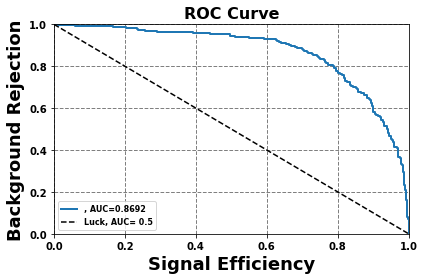

In [35]:
# Let's train again
vqc = VQC(encoding_circuit, variational_circuit, 
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','qAUC'], loss='mse',
          readout=[variational_circuit.readout_measurement()], trainable_dense_layer=False)
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=100, callbacks=[logger])